# All the News 
## Data Analysis for Political Data Science
by Nico Hertel

Data is obtained from https://www.kaggle.com/snapcrack/all-the-news

## Step 1: Explore Data
 - What data is in the database?
 - How many publications, articles and words are there?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
%matplotlib inline

In [3]:
articles1 = pd.read_csv('articles1.csv')
articles2 = pd.read_csv('articles2.csv')
articles3 = pd.read_csv('articles3.csv')

In [5]:
articles1.head(1)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...


In [8]:
articles1.describe()

,Unnamed: 0,id,year,month,url
count,50000.000000,50000.000000,50000.000000,50000.000000,0.0
mean,25694.378380,44432.454800,2016.273700,5.508940,NaN
std,15350.143677,15773.615179,0.634694,3.333062,NaN
min,0.000000,17283.000000,2011.000000,1.000000,NaN
25%,12500.750000,31236.750000,2016.000000,3.000000,NaN
50%,25004.500000,43757.500000,2016.000000,5.000000,NaN
75%,38630.250000,57479.250000,2017.000000,8.000000,NaN
max,53291.000000,73469.000000,2017.000000,12.000000,NaN


In [4]:
# Merging the individual files
articles = pd.concat([articles1, articles3, articles3])
articles.info()
del(articles1, articles2, articles3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135142 entries, 0 to 42570
Data columns (total 10 columns):
Unnamed: 0     135142 non-null int64
id             135142 non-null int64
title          135140 non-null object
publication    135142 non-null object
author         126892 non-null object
date           135112 non-null object
year           135112 non-null float64
month          135112 non-null float64
url            85142 non-null object
content        135142 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 11.3+ MB


### Saving Results in a new DataFrame
Before continuing, I will create a new DataFrame that later can be used to train the word2ved-models. This DataFrame should consist of the name of the publication, the number of articles, the number of words, the word-to-article-ratio, the number of unique words, the list of unique words and finaly the list of all words for training.

In [5]:
sources = articles['publication'].unique()
columns=['Publications', 'Number of Articles', 'Number of Words', 'Word/Article Ratio', 
         'Number of Unique Words', 'Unique Words', 'Words']
data = pd.DataFrame(columns=columns)
data['Publications'] = sources
data.set_index('Publications', inplace=True)

In [2]:
# Loading the DataFrame
data = pd.read_pickle('311018_005720_data.pickle')

,publication,content
0,Atlantic,"As a presidential candidate, Barack Obama prom..."
1,Breitbart,On Tuesday’s broadcast of CNN’s “Situation Roo...
2,Business Insider,"’ ’ ’ On the final day of 2016, Donald Tr..."
3,CNN,Istanbul (CNN) At least 39 people were killed ...
4,Guardian,The son of a Louisiana man whose father was sh...
5,NPR,"In the Washington of 2016, even when the polic..."
6,New York Times,WASHINGTON — Congressional Republicans have...
7,Reuters,U. S. Donald Trump on Friday praised Russia...
8,Vox,People have dreamed about flying cars for dec...
9,Washington Post,The Islamic State starts the new year with a ...


In [6]:
# Extracting Articles for different news sources
complete_articles = dict() # All articles in one string
texts = articles.groupby('publication')['content'].apply(' '.join).reset_index() 

for source in sources:
    complete_articles[source] = texts[texts['publication'] == source]['content'].values[0]
    n = len(complete_articles[source])
    data.loc[source, 'Number of Articles'] = sum(articles['publication'] == source)
    data.loc[source, 'Number of Words'] = n
    data.loc[source, 'Word/Article Ratio'] = n/sum(articles['publication'] == source)
    
del(n, source)

In [39]:
data['Number of Articles']

Publications
New York Times       7803
Breitbart           23781
CNN                 11488
Business Insider     6757
Atlantic              171
Guardian             7616
NPR                 23984
Reuters             21420
Vox                  9894
Washington Post     22228
Name: Number of Articles, dtype: object

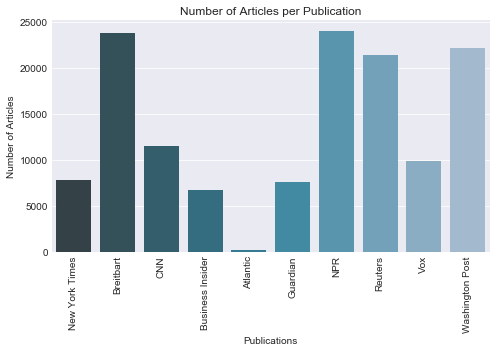

In [56]:
# Plot number of articles per publication
sns.set_style('darkgrid')
sns.set_palette('PuBuGn_d')
plt.figure(figsize=(7, 5))
sns.barplot(y=data['Number of Articles'], x=data.index, palette='PuBuGn_d')
plt.xticks(rotation='vertical')
plt.title('Number of Articles per Publication')
plt.tight_layout()
savename = time.strftime("Plots/%d%m%y_%H%M%S_") + 'ArticlesPerPublication.png'
plt.savefig(savename, dpi=600)
plt.show()

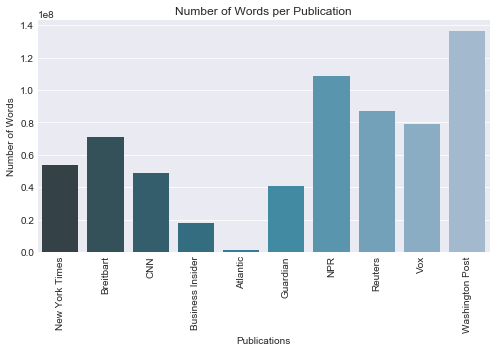

In [57]:
# Plot number of words per publication
plt.figure(figsize=(7, 5))
sns.barplot(x=data.index, y=data['Number of Words'], palette='PuBuGn_d')
plt.xticks(rotation='vertical')
plt.title('Number of Words per Publication')
plt.tight_layout()

savename = time.strftime("%d%m%y_%H%M%S_") + 'WordsPerPublication.png'
plt.savefig(savename, dpi=600)
plt.show()

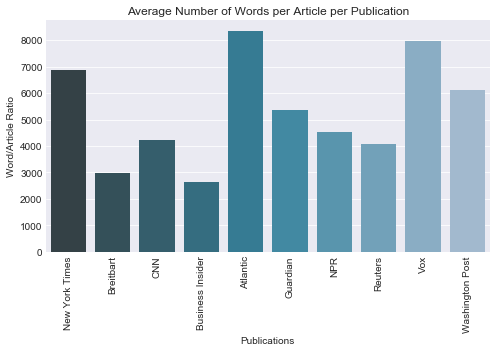

In [58]:
# Plot average words per article per Publication
plt.figure(figsize=(7, 5))
sns.barplot(x=data.index, y=data['Word/Article Ratio'], palette='PuBuGn_d')
plt.xticks(rotation='vertical')
plt.title('Average Number of Words per Article per Publication')
plt.tight_layout()

savename = time.strftime("%d%m%y_%H%M%S_") + 'AverageWordsPerPublication.png'
plt.savefig(savename, dpi=600)
plt.show()

### Summary of Dataset
 - Big difference in number of articles and numbers of words for different publications:
 - Between 171 (The Atlantic) and 23984 (NPR) articles per publication
 - Between $1.4\cdot 10^6$ and $1.3 \cdot 10^8$ words per publication
 - Popably exclude The Atlantic and Business Insider due to too few words

### Next Steps:
 - Preprocess text and look at number of unique words

## Step 2: Clean Text
 - Two phases: General clean up and publication specific cleanup
 - Requieres nltk package installed and downloaded

##### General Clean Up
 1. Split into tokens
 2. Remove punctiation
 3. Normalize case
 4. Remove non-alphabetic tokens

A usual step in preparing text for NLP is to remove stopwords like 'this' 'me' or 'them' and stemming the words (only keeping the base case of a word, e.g. 'walking' and removing any other cases like 'walked'). There are two reasons why I did not remove the stopwords in this instance. First, most stopword-lists, like the one from NLTK, include male and female words like 'he' and 'she'. Removing those words would have a strong impact on the bias-detection. Second, the word2vec-algorithm will automaticly put similar words in context. Therefore removing words from the dataset will only remove information. If, when training the word2vec-models, I realice that training on the full word dataset requieres to much computational power I can still use said processes. (See Tomas Mikolovs anwser here: https://groups.google.com/forum/#!msg/word2vec-toolkit/jPfyP6FoB94/tGzZxScO0GsJ)

In [47]:
import nltk

In [ ]:
nltk.download()

In [46]:
def text_cleanup(text):
    '''
    Cleans the passed text. This means splitting the text into word-tokens, removing punctiation, normalizing case
    to lower case and removing non-alphabetic tokens

    Parameters
    ----------
    text : str
        The text-string to be cleaned

    Returns
    -------
    words : list
        List of cleaned word-tokens
    '''
    tokens = nltk.word_tokenize(text)
    words = [word.lower() for word in tokens if word.isalpha()]

    return words

In [48]:
for source in sources:
    print('Currently processing %s' % source)
    data.loc[source, 'Words'] = text_cleanup(complete_articles[source])
    data.loc[source, 'Unique Words'] = list(set(data.loc[source, 'Words'])) 
    data.loc[source, 'Number of Unique Words'] = len(data.loc[source, 'Unique Words']) 
del(source)

Currently processing New York Times
Currently processing Breitbart
Currently processing CNN
Currently processing Business Insider
Currently processing Atlantic
Currently processing Guardian
Currently processing NPR
Currently processing Reuters
Currently processing Vox
Currently processing Washington Post


In [54]:
# Save DataFrame
import time

savename = time.strftime("%d%m%y_%H%M%S_") + 'data.pickle'
data.to_pickle(savename)

In [ ]:
data = pd.read_pickle('311018_005720_data.pickle')

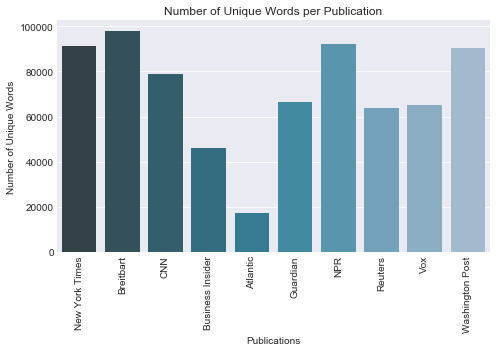

In [59]:
# Plot number of unique words
plt.figure(figsize=(7, 5))
sns.barplot(x=data.index, y=data['Number of Unique Words'], palette='PuBuGn_d')
plt.xticks(rotation='vertical')
plt.title('Number of Unique Words per Publication')
plt.tight_layout()

savename = time.strftime("%d%m%y_%H%M%S_") + 'UniqueWordsPerPublication.png'
plt.savefig(savename, dpi=600)
plt.show()

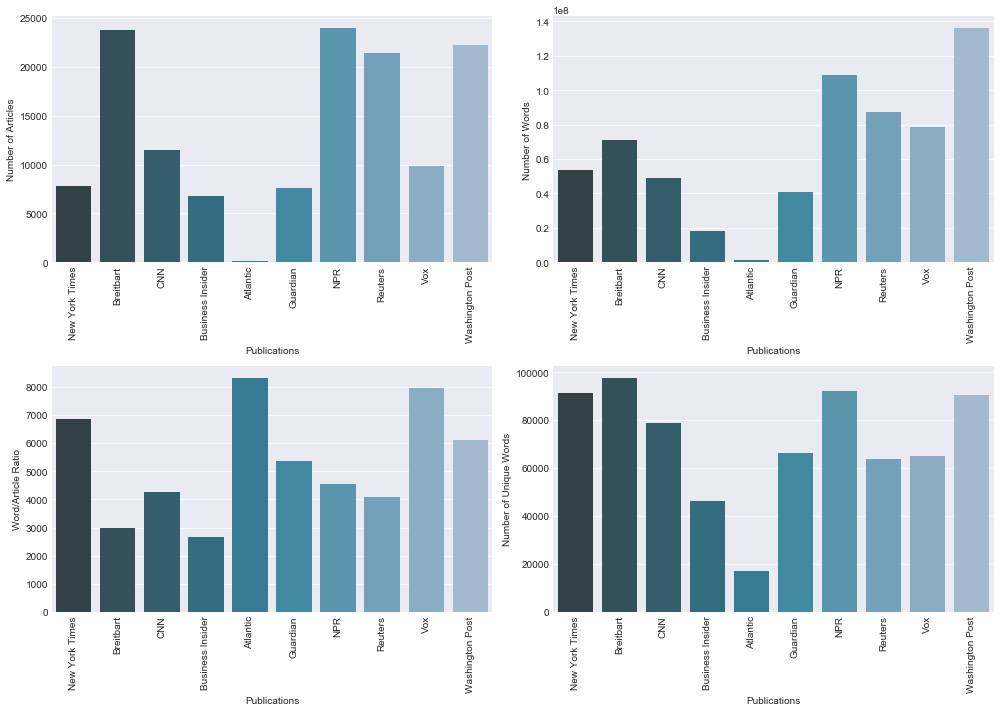

In [60]:
# Create figure with all plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot number of articles per publication
sns.barplot(y=data['Number of Articles'], x=data.index, palette='PuBuGn_d', ax=ax[0][0])
plt.xticks(rotation='vertical')
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=90)


# Plot number of words per publication
sns.barplot(x=data.index, y=data['Number of Words'], palette='PuBuGn_d', ax=ax[0][1])
plt.xticks(rotation='vertical')
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=90)

# Plot average words per article per Publication
sns.barplot(x=data.index, y=data['Word/Article Ratio'], palette='PuBuGn_d', ax=ax[1][0])
plt.xticks(rotation='vertical')
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=90)

# Plot number of unique words
sns.barplot(x=data.index, y=data['Number of Unique Words'], palette='PuBuGn_d', ax=ax[1][1])
plt.xticks(rotation='vertical')
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=90)


savename = time.strftime("%d%m%y_%H%M%S_") + 'DataExploration.pdf'
fig.tight_layout()
fig.savefig(savename, dpi=600)

### Creating Wordclouds

Creating wordclouds for each publication with the 100 most frequent words. 

In [ ]:
from wordcloud import WordCloud

In [43]:
# Creat elliptic mask for the shape of the wordcloud
x, y = np.ogrid[:800, :1600]
mask = (x/0.5 - 800) ** 2 + (y - 800) ** 2 > 700 ** 2
mask = 255 * mask.astype(int)


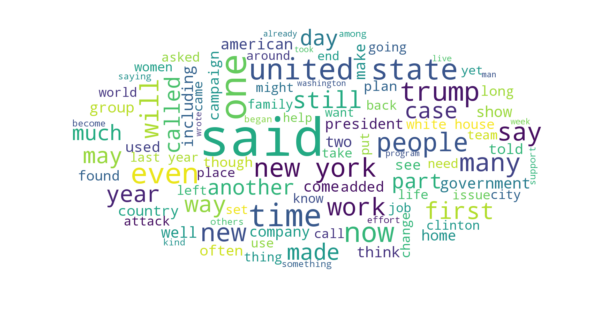

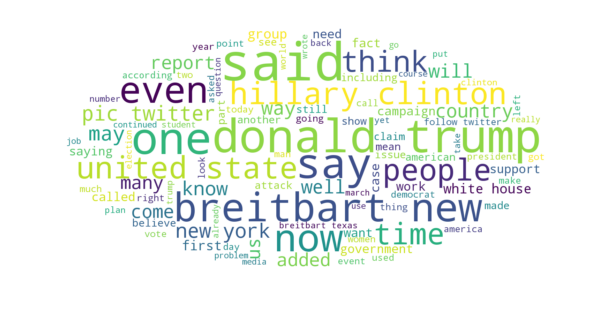

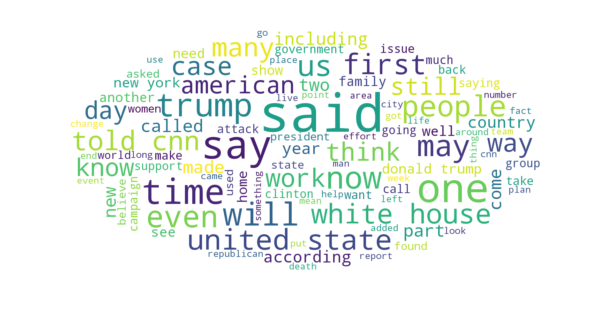

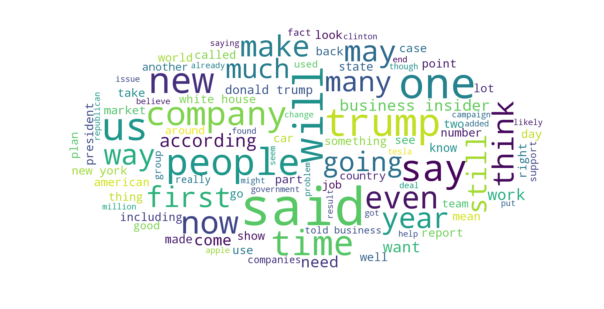

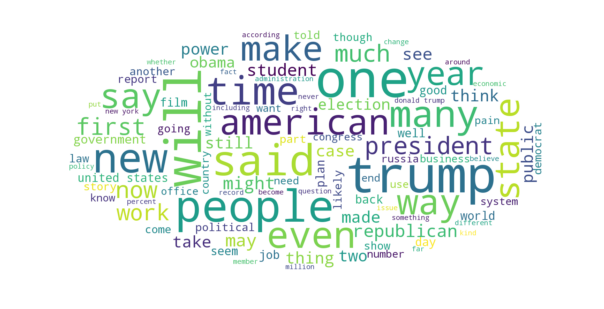

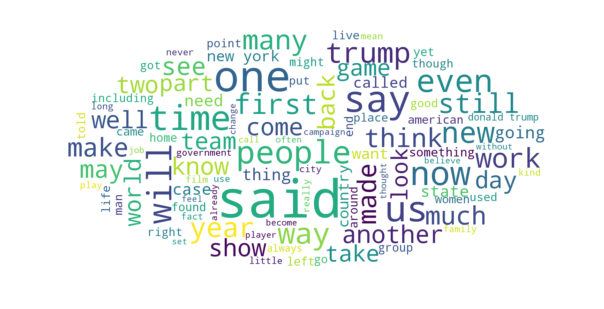

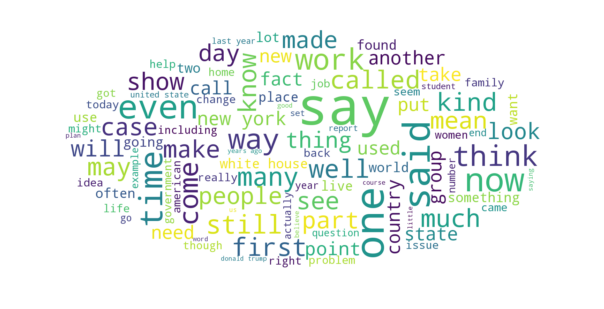

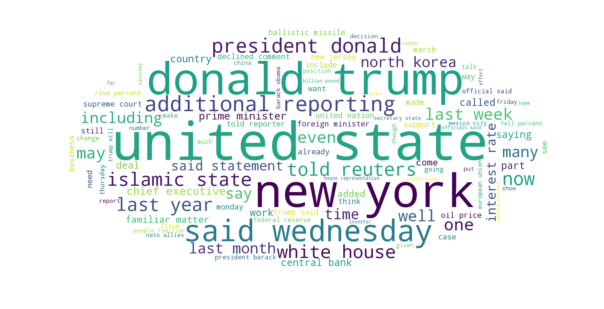

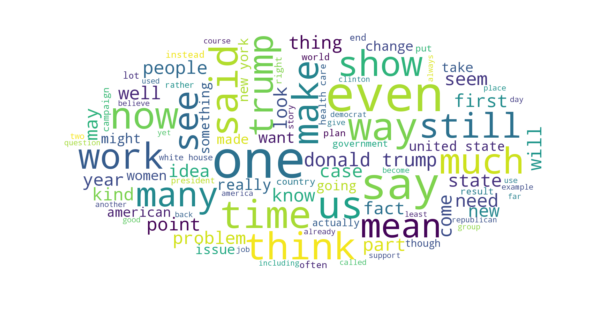

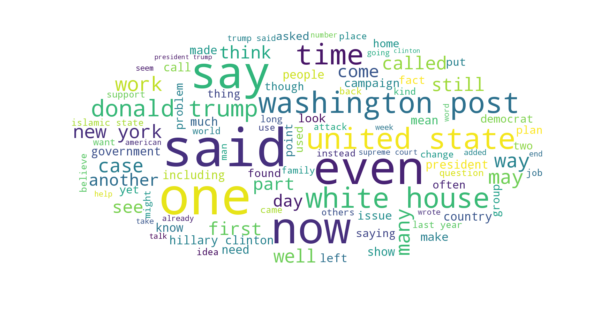

In [60]:
for publication in data.index:
    wordcloud = WordCloud(mask=mask, max_font_size=150, max_words=100,
                      background_color="white").generate(' '.join(data.loc[publication, 'Words']))
    plt.figure(figsize=(10, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    # plt.title(publication)
    savename = time.strftime("Plots/Wordclouds/%d%m%y_%H%M%S_") + 'WordCloud_%s.png' % publication
    plt.savefig(savename, dpi=900)


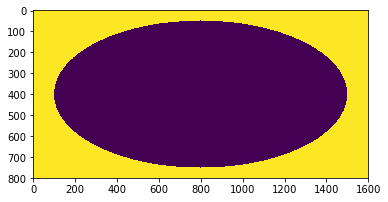

'New York Times'